In [1]:
import pydicom

In [2]:
import dicom

/usr/local/lib/python3.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [10]:
from os import path

In [11]:
roi.ContourSequence[4].ContourImageSequence[0].ReferencedSOPInstanceUID

NameError: name 'roi' is not defined

In [3]:
dicom.read_file("../data/386662/RS.386662.MR_1.dcm")

RuntimeError: generator raised StopIteration

In [4]:
current_id = "386662"

plan = dicom.read_file("../data/{}/RS.{}.MR_1.dcm".format(current_id, current_id))

uid_contour_dict = dict()
for roi in plan.ROIContourSequence:
    for contour in roi.ContourSequence:
        assert len(contour.ContourImageSequence) == 1
        cur_uid = contour.ContourImageSequence[0].ReferencedSOPInstanceUID
        uid_contour_dict[cur_uid] = contour.ContourData
#         images_of_interest.append()
#     cur_roi_uids.append(roi.ContourSequence[0].ReferencedFrameOfReferenceUID)

PREFIX = "../data/{}/".format(current_id)
filenames = !ls $PREFIX

uid_filename_dict = dict()
for filename in filenames:
    dicom_image = dicom.read_file(path.join(PREFIX, filename))
    uid_filename_dict[dicom_image.SOPInstanceUID] = filename
    print(filename, dicom_image.SOPInstanceUID)

RuntimeError: generator raised StopIteration

In [5]:
dicom.read_file

<function dicom.filereader.read_file(fp, defer_size=None, stop_before_pixels=False, force=False)>

In [6]:
uid_filename_dict

NameError: name 'uid_filename_dict' is not defined

In [132]:
uid_filename_dict

{'1.2.246.352.205.4638382753021146037.5065850434439371170': 'RS.386800.MR_1.dcm',
 '1.2.246.352.205.4937877331088157822.13767625261305553820': 'RE.386800.REGISTRATION.dcm',
 '1.2.246.352.205.5313781769112990200.6994104619905084810': 'RS.386800.Plan_0.dcm',
 '1.3.12.2.1107.5.1.4.65763.30000017060707195877000000350': 'CT.386800.Image 5.dcm',
 '1.3.12.2.1107.5.1.4.65763.30000017060707195877000000351': 'CT.386800.Image 6.dcm',
 '1.3.12.2.1107.5.1.4.65763.30000017060707195877000000352': 'CT.386800.Image 7.dcm',
 '1.3.12.2.1107.5.1.4.65763.30000017060707195877000000353': 'CT.386800.Image 8.dcm',
 '1.3.12.2.1107.5.1.4.65763.30000017060707195877000000354': 'CT.386800.Image 9.dcm',
 '1.3.12.2.1107.5.1.4.65763.30000017060707195877000000355': 'CT.386800.Image 10.dcm',
 '1.3.12.2.1107.5.1.4.65763.30000017060707195877000000356': 'CT.386800.Image 11.dcm',
 '1.3.12.2.1107.5.1.4.65763.30000017060707195877000000357': 'CT.386800.Image 12.dcm',
 '1.3.12.2.1107.5.1.4.65763.30000017060707195877000000358': 

['-32.2265625', '-321.646484375', '1068.5', '-31.0546875', '-321.58091517857', '1068.5', '-30.387931034483', '-321.3046875', '1068.5', '-29.8828125', '-321.10673564189', '1068.5', '-28.7109375', '-320.85867537313', '1068.5', '-27.5390625', '-320.16162909836', '1068.5', '-27.491554054054', '-320.1328125', '1068.5', '-26.3671875', '-319.28380102041', '1068.5', '-26.084681919643', '-318.9609375', '1068.5', '-25.48828125', '-317.7890625', '1068.5', '-25.1953125', '-317.14034598214', '1068.5', '-24.928977272727', '-316.6171875', '1068.5', '-24.912806919643', '-315.4453125', '1068.5', '-25.083111702128', '-314.2734375', '1068.5', '-25.1953125', '-314.15079941861', '1068.5', '-26.13525390625', '-313.1015625', '1068.5', '-26.3671875', '-312.88746995192', '1068.5', '-27.5390625', '-312.69591346154', '1068.5', '-28.7109375', '-312.83522727273', '1068.5', '-29.8828125', '-312.92578125', '1068.5', '-31.0546875', '-313.00739397321', '1068.5', '-31.34765625', '-313.1015625', '1068.5', '-32.2265625',

In [ ]:
IDX = 0

In [149]:
plan

(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0012) Instance Creation Date              DA: '20181011'
(0008, 0013) Instance Creation Time              TM: '071830'
(0008, 0016) SOP Class UID                       UI: RT Structure Set Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.246.352.205.5313781769112990200.6994104619905084810
(0008, 0020) Study Date                          DA: '20170607'
(0008, 0030) Study Time                          TM: '103043.147'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'RTSTRUCT'
(0008, 0070) Manufacturer                        LO: 'Varian Medical Systems'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 1010) Station Name                        SH: 'variancombo'
(0008, 1030) Study Description                   LO: 'Head^Stereo (Adult)'
(0008, 103e) Series Description                  LO: 'ARIA RadOnc Structure Sets'
(0008, 1048) 

In [150]:
dicom_image

(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0012) Instance Creation Date              DA: '20181011'
(0008, 0013) Instance Creation Time              TM: '071804'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.65763.30000017060707195877000000350
(0008, 0020) Study Date                          DA: '20170607'
(0008, 0021) Series Date                         DA: '20170607'
(0008, 0022) Acquisition Date                    DA: '20170607'
(0008, 0023) Content Date                        DA: '20170607'
(0008, 0030) Study Time                          TM: '103043.147'
(0008, 0031) Series Time                         TM: '104140.09'
(0008, 0032) Acquisition Time                    TM: '104111.53'
(0008, 0033) Content Time                        TM: '104111.53'
(0008, 0050

In [152]:
import numpy as np

In [211]:
IDX = 0

In [213]:
current_id

'386800'

In [214]:
image_name

'CT.386800.Image 38.dcm'

In [218]:
"../data/{}/{}".format(current_id, image_name)

'../data/386800/CT.386800.Image 5.dcm'

In [219]:
image_uid

'1.3.12.2.1107.5.1.4.65763.30000017060707195877000000350'

In [221]:
uid_filename_dict["1.3.12.2.1107.5.1.4.65763.30000017060707195877000000427"]

'CT.386800.Image 82.dcm'

In [222]:
dicom_image

(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0012) Instance Creation Date              DA: '20181011'
(0008, 0013) Instance Creation Time              TM: '071804'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.65763.30000017060707195877000000350
(0008, 0020) Study Date                          DA: '20170607'
(0008, 0021) Series Date                         DA: '20170607'
(0008, 0022) Acquisition Date                    DA: '20170607'
(0008, 0023) Content Date                        DA: '20170607'
(0008, 0030) Study Time                          TM: '103043.147'
(0008, 0031) Series Time                         TM: '104140.09'
(0008, 0032) Acquisition Time                    TM: '104111.53'
(0008, 0033) Content Time                        TM: '104111.53'
(0008, 0050

In [224]:
dicom.read_file("../data/{}/{}".format(current_id, image_name))

(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0012) Instance Creation Date              DA: '20181011'
(0008, 0013) Instance Creation Time              TM: '071804'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.65763.30000017060707195877000000350
(0008, 0020) Study Date                          DA: '20170607'
(0008, 0021) Series Date                         DA: '20170607'
(0008, 0022) Acquisition Date                    DA: '20170607'
(0008, 0023) Content Date                        DA: '20170607'
(0008, 0030) Study Time                          TM: '103043.147'
(0008, 0031) Series Time                         TM: '104140.09'
(0008, 0032) Acquisition Time                    TM: '104111.53'
(0008, 0033) Content Time                        TM: '104111.53'
(0008, 0050

In [234]:
IDX = 0

In [236]:
"../data/{}/{}".format(current_id, image_name)

'../data/386800/CT.386800.Image 38.dcm'

In [253]:
dicom_images = [dicom.read_file(path.join(PREFIX, f)) for f in filenames if "CT" in f]

In [ ]:
dicom_image.ImagePositionPatient

In [260]:
def f(img):
    try:
#         print(img.ImagePositionPatient)
        return img.SliceLocation
    except AttributeError:
        return -1000000
d_i_sorted = sorted(dicom_images, key=f, reverse=True)

In [274]:
new_arr = np.array(d_i_sorted[48].pixel_array / d_i_sorted[48].pixel_array.max(), dtype=np.float32)

In [276]:
from skimage import exposure

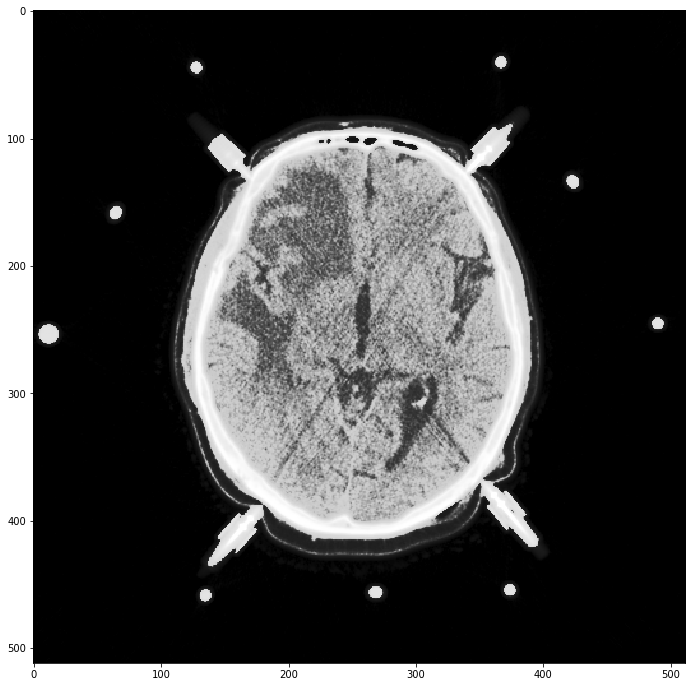

In [277]:
plt.figure(figsize=(12, 12))
plt.imshow(exposure.equalize_hist(new_arr))

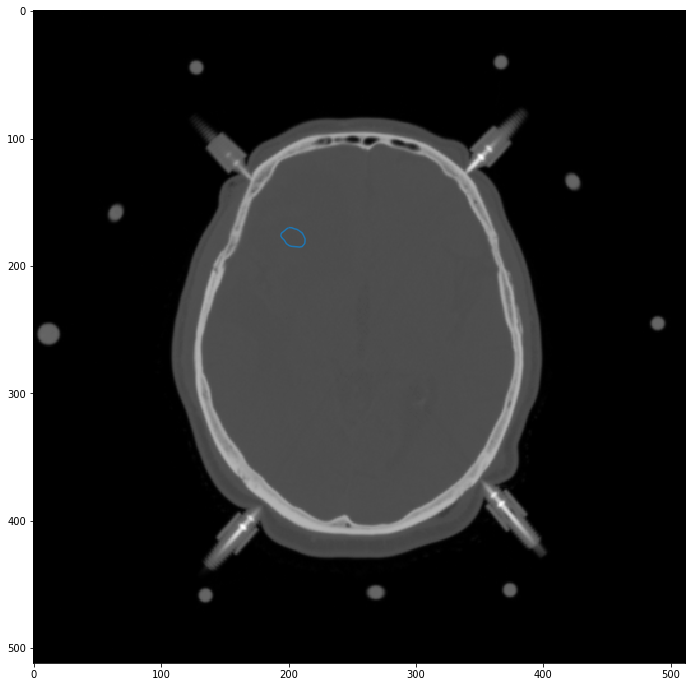

In [235]:
image_uid = images_of_interest[IDX]
image_name = uid_filename_dict[image_uid]
dicom_image = dicom.read_file("../data/{}/{}".format(current_id, image_name))
image = dicom_image.pixel_array
plt.figure(figsize=(12, 12))
plt.imshow(image)

contour_data = uid_contour_dict[image_uid]
scale_x, scale_y = dicom_image.PixelSpacing
shift_x, shift_y, _ = dicom_image.ImagePositionPatient
xs = np.array(contour_data[::3]) - shift_x
ys = np.array(contour_data[1::3]) - shift_y

xs /= scale_x
ys /= scale_y

zs = contour_data[2::3]

plt.plot(xs, ys)

# IDX += 1

In [85]:
seq = plan.ROIContourSequence[0]

(3006, 002a) ROI Display Color                   IS: ['0', '150', '0']
(3006, 0040)  Contour Sequence   7 item(s) ---- 
   (3006, 0016)  Contour Image Sequence   1 item(s) ---- 
      (0008, 1150) Referenced SOP Class UID            UI: CT Image Storage
      (0008, 1155) Referenced SOP Instance UID         UI: 1.3.12.2.1107.5.1.4.65763.30000017060707195877000000391
      ---------
   (3006, 0042) Contour Geometric Type              CS: 'CLOSED_PLANAR'
   (3006, 0046) Number of Contour Points            IS: '30'
   (3006, 0050) Contour Data                        DS: ['-53.3203125', '-271.08984375', '1084.5', '-52.1484375', '-271.12815504808', '1084.5', '-51.03515625', '-270.9140625', '1084.5', '-50.9765625', '-270.90614442568', '1084.5', '-49.8046875', '-270.63550204918', '1084.5', '-48.966346153846', '-269.7421875', '1084.5', '-48.6328125', '-269.12276785714', '1084.5', '-48.203125', '-268.5703125', '1084.5', '-47.4609375', '-267.828125', '1084.5', '-47.133209745763', '-267.3984375',

In [95]:
seq.RefdROINumber

'1'

In [96]:
seq = plan.StructureSetROISequence[0]

In [ ]:
seq.ReferencedFrameOfReferenceUID

In [18]:
one_image.ROIContourSequence[0]

(3006, 002a) ROI Display Color                   IS: ['255', '0', '0']
(3006, 0040)  Contour Sequence   1 item(s) ---- 
   (3006, 0016)  Contour Image Sequence   1 item(s) ---- 
      (0008, 1150) Referenced SOP Class UID            UI: CT Image Storage
      (0008, 1155) Referenced SOP Instance UID         UI: 1.3.12.2.1107.5.1.4.65763.30000017060707195877000000383
      ---------
   (3006, 0042) Contour Geometric Type              CS: 'POINT'
   (3006, 0046) Number of Contour Points            IS: '1'
   (3006, 0050) Contour Data                        DS: ['-2.84784', '-275.249', '1069.06']
   ---------
(3006, 0084) Referenced ROI Number               IS: '1'

In [21]:
seq = one_image.ROIContourSequence[1]

In [30]:
seq.keys()

dict_keys([(3006, 002a), (3006, 0040), (3006, 0084)])

In [32]:
contour_data = seq.ContourSequence[0].ContourData

In [7]:
from matplotlib import pyplot as plt

%matplotlib inline

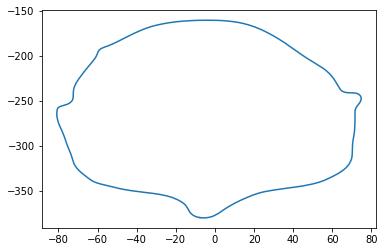

In [36]:
plt.plot(xs, ys)

In [37]:
plt.figure(figsize=(12, 12))
plt.set_cmap("gray")
plt.imshow(one_image.pixel_array)

TypeError: No pixel data found in this dataset.

<Figure size 864x864 with 0 Axes>

In [1]:
import numpy as np

In [4]:
l = np.load('../varian/services/380677.npz')

In [35]:
x = l['X']

In [36]:
y = l['Y']

In [14]:
x.max()

22379.0

In [25]:
x_n = np.array(x / x.max(), dtype=np.float32)

In [30]:
x_n.min()

0.0

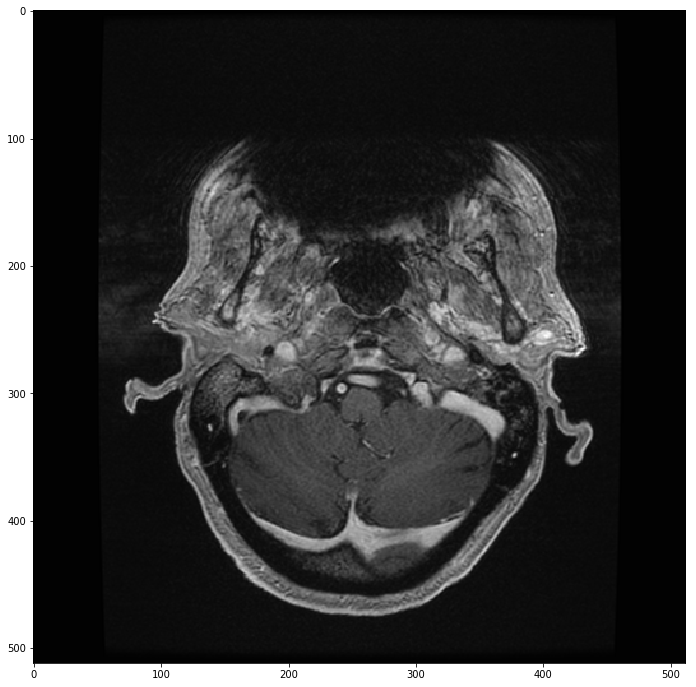

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline
from skimage import exposure

plt.figure(figsize=(12, 12))
# plt.imshow(exposure.equalize_hist(x[1]))
plt.imshow(x_n[70], cmap=plt.get_cmap('gray'))

In [46]:
plt.figure(figsize=(12, 12))
plt.set_cmap("gray")

# plt.imshow(exposure.equalize_hist(x[1]))
# plt.imshow(y[70], cmap=plt.get_cmap('gray'))

for i, img in enumerate(y):
    plt.imsave("/tmp/{}.png".format(i), img, cmap=plt.get_cmap('gray'))

<Figure size 864x864 with 0 Axes>